Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [2]:
#Carregando o dataset
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#Verificando a quantidade de valores null
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

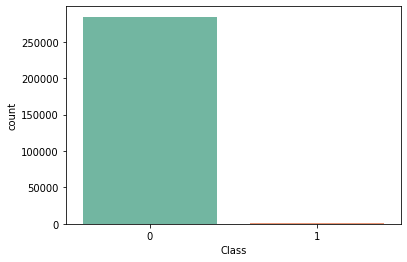

In [5]:
#Verificando o balanceamento da variável class
sns.countplot(data['Class'],palette='Set2')

In [6]:
#Verificando a quantidade de valores Class=1
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Como a classe está muito desbalanceada, vamos filtrar os dados e equilibrá-los. Para isso, escolhemos 492 dados aleatórios
que possuem a variável Class=0.

In [7]:
data2 = data[data['Class']==0]

In [8]:
sample = data2.sample(492)

In [9]:
sample2 = data[data['Class']==1]

In [10]:
df = pd.concat([sample, sample2])

In [11]:
df.reset_index()

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,261900,160232.0,2.103815,-0.430247,-1.756160,-1.440195,-0.167507,-1.737122,0.367717,-0.492897,...,-0.127050,-0.164425,0.116189,-0.083953,0.131677,-0.308293,-0.033888,-0.062167,25.07,0
1,92225,63830.0,0.871083,-1.451768,0.937697,-0.862488,-1.634564,0.290455,-0.908856,0.316061,...,-0.078304,-0.089326,-0.247377,0.089311,0.431213,0.078310,0.031439,0.036556,169.55,0
2,104909,69284.0,-0.269709,0.293363,1.290351,-0.705239,0.330381,0.966680,0.333365,0.068998,...,-0.615855,-1.275460,-0.087708,-1.452346,-0.285147,-0.676078,-0.173781,-0.183685,34.30,0
3,27650,34643.0,-0.685332,0.561291,2.500434,0.278998,-0.070013,-0.211827,0.451755,-0.153068,...,0.019469,0.403304,-0.078256,0.409586,-0.248011,-0.647754,-0.101687,-0.060801,9.99,0
4,278910,168517.0,2.083308,-0.105768,-1.727740,-0.005150,0.557887,-0.267997,0.061260,-0.101895,...,0.245644,0.782911,-0.052260,0.116966,0.328988,-0.121700,-0.031912,-0.068784,2.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
980,280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
981,280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
982,281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


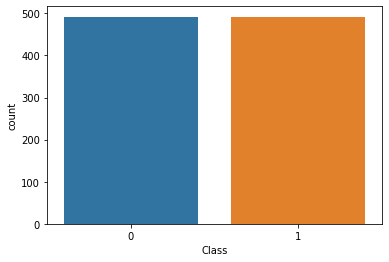

In [12]:
#Verificando o balanceamento
sns.countplot(df['Class'])

In [13]:
#Verificando os tipos dos dados
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

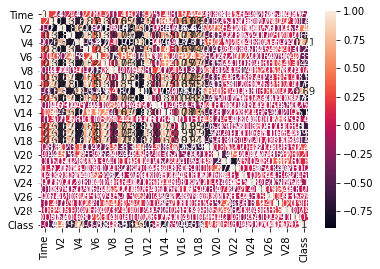

In [14]:
corr = df.corr()

sns.heatmap(corr, annot=True)


In [15]:
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
261900,2.103815,-0.430247,-1.756160,-1.440195,-0.167507,-1.737122,0.367717,-0.492897,1.549670,-0.867988,...,-0.127050,-0.164425,0.116189,-0.083953,0.131677,-0.308293,-0.033888,-0.062167,0,-0.342632
92225,0.871083,-1.451768,0.937697,-0.862488,-1.634564,0.290455,-0.908856,0.316061,2.620167,-1.310350,...,-0.078304,-0.089326,-0.247377,0.089311,0.431213,0.078310,0.031439,0.036556,0,0.247908
104909,-0.269709,0.293363,1.290351,-0.705239,0.330381,0.966680,0.333365,0.068998,-1.373557,0.781960,...,-0.615855,-1.275460,-0.087708,-1.452346,-0.285147,-0.676078,-0.173781,-0.183685,0,-0.304906
27650,-0.685332,0.561291,2.500434,0.278998,-0.070013,-0.211827,0.451755,-0.153068,0.449306,-0.531045,...,0.019469,0.403304,-0.078256,0.409586,-0.248011,-0.647754,-0.101687,-0.060801,0,-0.404269
278910,2.083308,-0.105768,-1.727740,-0.005150,0.557887,-0.267997,0.061260,-0.101895,0.423958,0.187893,...,0.245644,0.782911,-0.052260,0.116966,0.328988,-0.121700,-0.031912,-0.068784,0,-0.432921


In [16]:
#Separando os dados em treino e teste
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Determinando um range de K
k_range = range(1,15)
# Aplicando o modelo K-Means para cada valor de K 
k_means_var = [KMeans(n_clusters = k).fit(X_train) for k in k_range]
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(X_train, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [18]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [19]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [20]:
# Soma total dos quadrados
soma_total = sum(pdist(X_train)**2)/X_train.shape[0]

In [21]:

# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

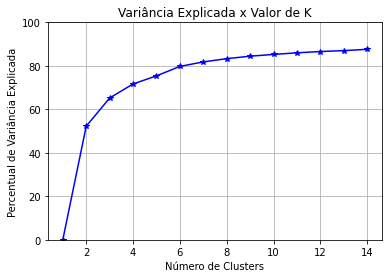

In [22]:

# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

In [23]:
# Criando um modelo com K = 4
modelo_v1 = KMeans(n_clusters = 7)
modelo_v1.fit(X_train)

KMeans(n_clusters=7)

In [24]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(X_train, labels, metric = 'euclidean')

0.4104537163978142


Matriz de Confusão:



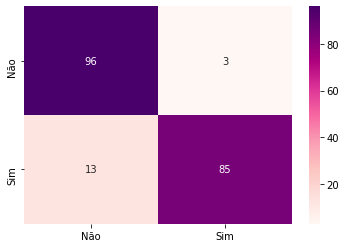


Relatório de Classificação:

               precision    recall  f1-score   support

           0       0.88      0.97      0.92        99
           1       0.97      0.87      0.91        98

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197



In [25]:
# Primeiro criamos o redutor de dimensionalidade
pca = PCA(n_components = 7)

# Treina e aplica o PCA em dados de treino
X_treino_b_scaled_pca = pca.fit_transform(X_train)

# Aplica o PCA em dados de teste
X_teste_b_scaled_pca = pca.transform(X_test)

# Criamos o classificador SVM com Kernel Linear
modelo_svm = svm.SVC(kernel = "linear", C = 0.025)

# Treina o modelo
modelo_svm.fit(X_treino_b_scaled_pca,y_train)
    
# Previsões com o modelo
resultado_svm = modelo_svm.predict(X_teste_b_scaled_pca)
    
# Matriz de confusão
print("\nMatriz de Confusão:\n")
conf_mat = confusion_matrix(y_test, resultado_svm)
tags = ["Não", "Sim"]
sns.heatmap(conf_mat, annot = True, xticklabels = tags, yticklabels = tags, cmap = "RdPu")
plt.show()



# Relatório de classificação
report_svm = classification_report(y_test, resultado_svm)
print("\nRelatório de Classificação:\n\n", report_svm)

## Modelo Random Forest


Matriz de Confusão:



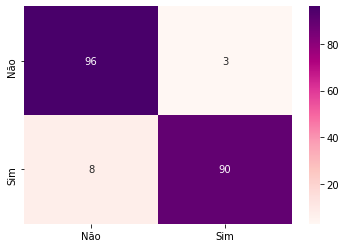


Relatório de Classificação:

               precision    recall  f1-score   support

           0       0.92      0.97      0.95        99
           1       0.97      0.92      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



In [26]:
# Criamos o classificador Random Forest
clf = RandomForestClassifier()

# Treina o modelo
modelo_clf = clf.fit(X_treino_b_scaled_pca,y_train)
    
# Previsões com o modelo
resultado_clf = modelo_clf.predict(X_teste_b_scaled_pca)
    
# Matriz de confusão
print("\nMatriz de Confusão:\n")
conf_mat = confusion_matrix(y_test, resultado_clf)
tags = ["Não", "Sim"]
sns.heatmap(conf_mat, annot = True, xticklabels = tags, yticklabels = tags, cmap = "RdPu")
plt.show()



# Relatório de classificação
report_clf = classification_report(y_test, resultado_clf)
print("\nRelatório de Classificação:\n\n", report_clf)

## XGBoost

In [40]:
modelo_xg = xgb.XGBClassifier(learning_rate = 0.01, 
                              max_depth = 3, 
                              n_estimators = 1000,
                             min_child_weight = 5,
                             gamma = 0.1,
                             reg_alpha=1,
                            reg_lambda=1.5)
modelo_xg.fit(X_treino_b_scaled_pca,y_train)

resultado2 = modelo_xg.predict_proba(X_teste_b_scaled_pca)[:,1]
valores_previstos2 = modelo_xg.predict(X_teste_b_scaled_pca)
score = roc_auc_score(y_test, resultado2)
score


0.9789734075448362

In [41]:
from sklearn import metrics
print(metrics.classification_report(y_test,valores_previstos2))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        99
           1       0.98      0.90      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197




Matriz de Confusão:



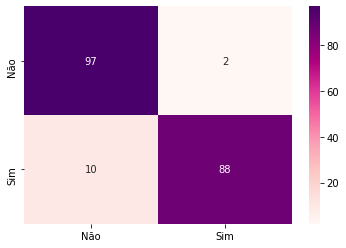

In [43]:
# Matriz de confusão
print("\nMatriz de Confusão:\n")
conf_mat = confusion_matrix(y_test,valores_previstos2)
tags = ["Não", "Sim"]
sns.heatmap(conf_mat, annot = True, xticklabels = tags, yticklabels = tags, cmap = "RdPu")
plt.show()